In [78]:
%matplotlib inline

# Feathering two data cubes

A general overview of all steps to check when feathering single dish and interferometric data together. It's written for data cubes, though the general approach should hold for continuum images, too (modulo additional effects from varying bandpasses).

Steps
-----
1. Match spectral resolution -- regrid/smooth to the coarsest resolution between the cubes
2. Spatial registration -- reproject and match spatial resolution. Check for spatial offsets
3. Apply equal spatial masking and/or weighting
    (a) mask by PB coverage of the interferometric data; 
    (b) weight edges of SD and interferometer by the PB values -- using this like an apodizing kernel
4. Calculate uv-overlap statistics
5. Measure the flux ratio
6. Feather the cubes together with the appropriate flux scaling.



In [79]:
import astropy.units as u
from astropy.convolution import Gaussian1DKernel

from spectral_cube import SpectralCube
from radio_beam import Beam

from regions import Regions

import matplotlib.pyplot as plt



from uvcombine.scale_factor import find_scale_factor

from cube_analysis.feather_cubes import feather_compare_cube


In [80]:
from astropy.coordinates import SkyCoord, EarthLocation, LSR
from astropy.time import Time

obstime = Time('2013-3-14')

target = SkyCoord.from_name('ic1613')
target = SkyCoord(ra=target.ra, dec=target.dec,
                  distance=760*u.kpc,
                  radial_velocity=-238*u.km/u.s,
                  pm_ra_cosdec=0*u.mas/u.yr,
                  pm_dec=0*u.mas/u.yr,
                  frame='lsrk')
gbt = EarthLocation.of_site('GBT')

vcorr = target.radial_velocity_correction('barycentric', 
                                          obstime=obstime, 
                                          location=gbt).to('km/s')
vcorr



<Quantity -12.13043958 km / s>

In [81]:
target

<SkyCoord (LSRK): (ra, dec, distance) in (deg, deg, kpc)
    (16.2016962, 2.1194959, 760.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0., 0., -238.)>

In [82]:
from pathlib import Path

# sd_data_path = Path("/Users/ekoch/storage/LGLBS/feathering_tests/")
# vla_data_path = Path("/Users/ekoch/storage/LGLBS/C+D_HI_2023/")

sd_data_path = Path("/reduction10/erickoch/LGLBS/hi_feathering/")
vla_data_path = Path("/reduction10/erickoch/LGLBS/C+D_HI_2023/")


In [122]:

# ngc6822
# vla_cube = SpectralCube.read(vla_data_path / "ngc6822_C+D_hilores.fits")
# vla_cube.allow_huge_operations = True

# # Nick's reprocessed and gridded GBT cube.
# gbt_cube = SpectralCube.read(sd_data_path / "NGC6822-center_cube.fits")

# vla_cube = SpectralCube.read(vla_data_path / "ic1613_C+D_hilores.fits")
vla_cube = SpectralCube.read(vla_data_path / "ic1613_C+D_himidres.fits")
# vla_cube = SpectralCube.read(vla_data_path / "ic1613_C+D_hi21cm_1p2kms.fits")
vla_cube.allow_huge_operations = True

# Nick's reprocessed and gridded GBT cube.
# gbt_cube = SpectralCube.read(sd_data_path / 'IC1613_GBT_Jy.fits')
# gbt_cube = SpectralCube.read(sd_data_path / 'IC1613_GBT_vegas_K_resampled_lsrk_cube.fits')
gbt_cube = SpectralCube.read(sd_data_path / 'IC1613_GBT_vegas_K_noresample_lsrk.fits')

# gbt_cube = SpectralCube.read(sd_data_path / 'IC10_GBT_Jy.fits')


# Use the proper beam model size, not the one in the header!
gbt_beam_model = Beam(area=3.69e5 *u.arcsec**2)
print(gbt_beam_model.major.to(u.arcmin))

gbt_cube = gbt_cube.with_beam(gbt_beam_model, raise_error_jybm=False)
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
print(gbt_cube.beam.major.to(u.arcmin))


9.511077544767847 arcmin
9.511077544767847 arcmin


In [123]:
vla_cube

SpectralCube with shape=(102, 1920, 1800) and unit=Jy / beam:
 n_x:   1800  type_x: RA---SIN  unit_x: deg    range:    15.323823 deg:   17.075400 deg
 n_y:   1920  type_y: DEC--SIN  unit_y: deg    range:     1.184156 deg:    3.049933 deg
 n_s:    102  type_s: VRAD      unit_s: m / s  range:  -342175.084 m / s: -133937.092 m / s

In [124]:
gbt_cube

SpectralCube with shape=(758, 128, 128) and unit=K:
 n_x:    128  type_x: RA---TAN  unit_x: deg    range:    14.326317 deg:   18.036159 deg
 n_y:    128  type_y: DEC--TAN  unit_y: deg    range:     0.274095 deg:    3.975073 deg
 n_s:    758  type_s: VRAD      unit_s: km / s  range:     -665.297 km / s:     309.839 km / s

### 1. Match spectral resolution -- regrid/smooth to the coarsest resolution between the cubes


In [125]:
gbt_cube = gbt_cube.with_spectral_unit(u.m / u.s, velocity_convention='radio')

fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = np.abs(np.diff(gbt_cube.spectral_axis)[0]).to(u.km / u.s)
target_resolution = np.abs(np.diff(vla_cube.spectral_axis)[0]).to(u.km / u.s)

print(current_resolution, target_resolution)

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  current_resolution / fwhm_factor)
print(gaussian_width)
# kernel = Gaussian1DKernel(gaussian_width.value)
# gbt_cube_specsmooth = gbt_cube.spectral_smooth(kernel)
# gbt_cube_specinterp = gbt_cube_specsmooth.spectral_interpolate(vla_cube.spectral_axis)

gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis)

1.2881592641429742 km / s 2.06176229853899 km / s
0.5307000349135832


In [126]:
gbt_cube_specinterp
# vla_cube

SpectralCube with shape=(102, 128, 128) and unit=K:
 n_x:    128  type_x: RA---TAN  unit_x: deg    range:    14.326317 deg:   18.036159 deg
 n_y:    128  type_y: DEC--TAN  unit_y: deg    range:     0.274095 deg:    3.975073 deg
 n_s:    102  type_s: VRAD      unit_s: m / s  range:  -342175.084 m / s: -133937.092 m / s

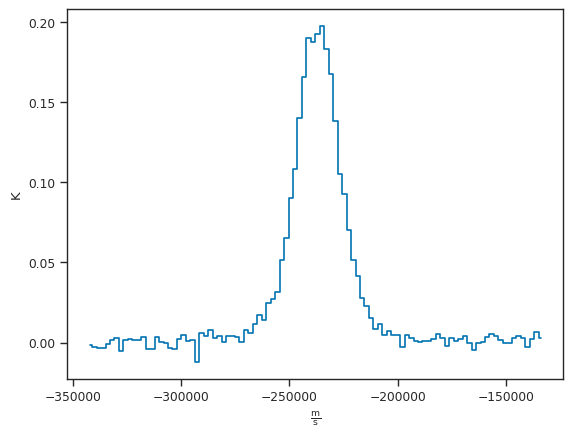

In [127]:
gbt_cube_specinterp.mean(axis=(1, 2)).quicklook()

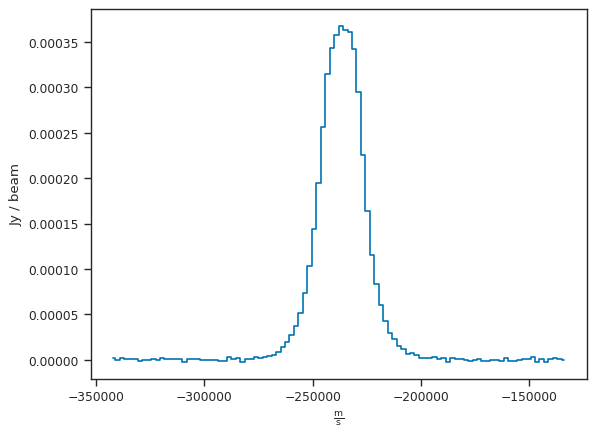

In [128]:
vla_cube.mean(axis=(1, 2)).quicklook()

### 2. Spatial registration -- reproject and match spatial resolution. Check for spatial offsets

In [14]:
from cube_analysis.register_cubes import cube_registration

In [134]:
# To speed up the computation, select a velocity range corresponding to the target of interest.

# ngc6822
# chan_min = vla_cube.closest_spectral_channel(-75 * u.km/u.s)
# chan_max = vla_cube.closest_spectral_channel(-25 * u.km/u.s)

# ic1613
# chan_min = gbt_cube_specinterp.closest_spectral_channel(-250 * u.km/u.s)
# chan_max = gbt_cube_specinterp.closest_spectral_channel(-210 * u.km/u.s)

chan_min = vla_cube.closest_spectral_channel(-265 * u.km/u.s)
chan_max = vla_cube.closest_spectral_channel(-210 * u.km/u.s)

if chan_min > chan_max:
    chan_min, chan_max = chan_max, chan_min

print(chan_min, chan_max)

spec_slicer = slice(chan_min, chan_max)


37 64


0.012215214082971215


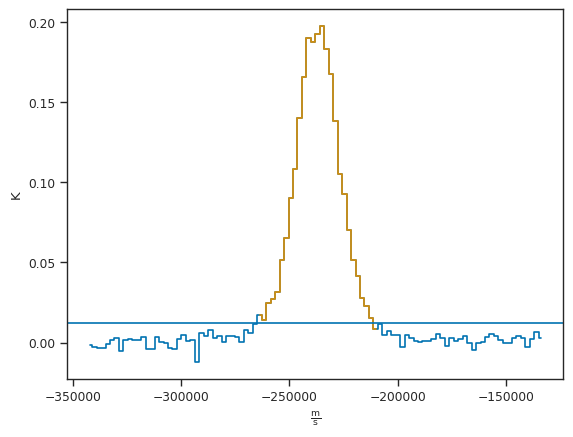

In [138]:
gbt_mean_spec = gbt_cube_specinterp.mean(axis=(1, 2))
gbt_mean_spec.quicklook()
gbt_cube_specinterp[spec_slicer].mean(axis=(1, 2)).quicklook()

plt.axhline(5 * np.std(gbt_mean_spec[:30].value))
print(5 * np.std(gbt_mean_spec[:30].value))


7.3940572065112065e-06


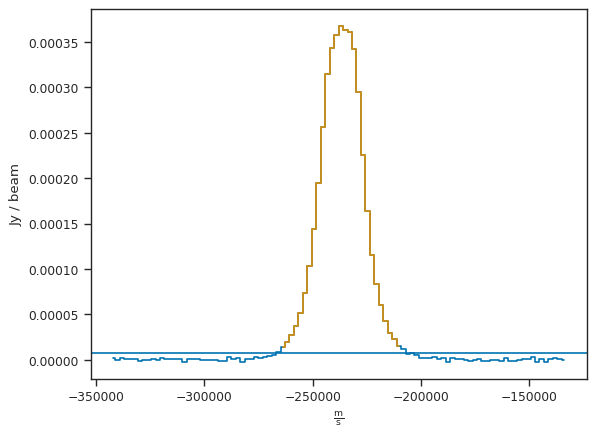

In [137]:
mean_spec = vla_cube.mean(axis=(1, 2))
mean_spec.quicklook()
mean_spec[spec_slicer].quicklook()

plt.axhline(5 * np.std(mean_spec[:30].value))
print(5 * np.std(mean_spec[:30].value))


In [108]:
# This function will smooth to the lowsest resolution and reproject per channel
# https://github.com/e-koch/CubeAnalysis/blob/master/cube_analysis/register_cubes.py#L58

spatial_offsets = cube_registration(gbt_cube_specinterp[spec_slicer],
                                    vla_cube[spec_slicer],
                                    verbose=True, num_cores=1,
                                    restfreq=1.42040575177 * u.GHz,
                                    check_specaxis=True,)


/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in scalar remainder
  if (i % chunksize) == 0:
/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in scalar remainder
  if (i % chunksize) == 0:
/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in scalar remainder
  if (i % chunksize) == 0:
/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in scalar remainder
  if (i % chunksize) == 0:
/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in scalar remainder
  if (i % chunksize) == 0:
/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in scalar remainder
  if (i % chunksize) == 0:
/home/erickoch/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by 

In [109]:
spatial_offsets[:, 0]

array([ 0.14285714,  0.21428571,  0.14285714,  0.14285714,  0.14285714,
       -0.        ,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
        0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
        0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
        0.07142857,  0.07142857,  0.14285714,  0.07142857,  0.14285714,
        0.14285714,  0.14285714,  0.14285714,  0.07142857,  0.14285714,
        0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
        0.14285714,  0.14285714,  0.14285714,  0.07142857,  0.07142857,
        0.07142857,  0.07142857,  0.07142857])

Text(0.5, 0, 'RA pixel offset')

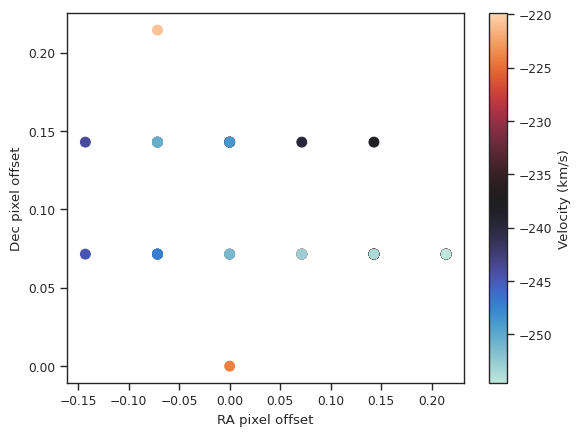

In [110]:
import seaborn as sns


# cmap = sns.cubehelix_palette(as_cmap=True)
cmap = sns.color_palette("icefire", as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(spatial_offsets[:, 1],
                    spatial_offsets[:, 0],
                    c=vla_cube[spec_slicer].spectral_axis.to(u.km / u.s).value,
                    s=50,
                    cmap=cmap)
f.colorbar(points, label="Velocity (km/s)")

ax.set_ylabel("Dec pixel offset")
ax.set_xlabel("RA pixel offset")

# Plot spatial offset as function of the channel:
# for yx in spatial_offsets:
#     plt.scatter(yx[0], yx[1])


This is far smaller than a single GBT pixel, and thus is within uncertainty for the GBT primary beam.

### 3. Apply equal spatial masking and/or weighting

Consider doing one of two:

1. mask by PB coverage of the interferometric data; 
2. weight edges of SD and interferometer by the PB values -- using this like an apodizing kernel

Demonstrating (1) here.

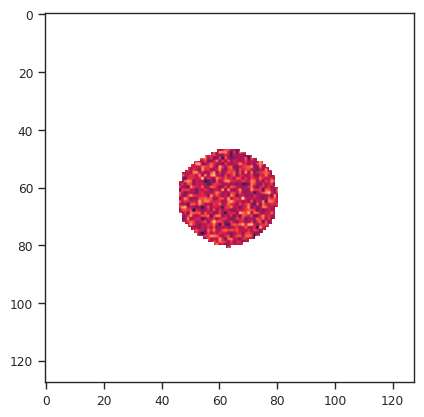

In [111]:
vla_reproj_plane = vla_cube[0].reproject(gbt_cube_specinterp[0].header)

vla_reproj_plane.quicklook()

In [131]:
gbt_cube_specinterp_masked = gbt_cube_specinterp.with_mask(np.isfinite(vla_reproj_plane)).minimal_subcube(spatial_only=True)
gbt_cube_masked = gbt_cube.with_mask(np.isfinite(vla_reproj_plane)).minimal_subcube(spatial_only=True)

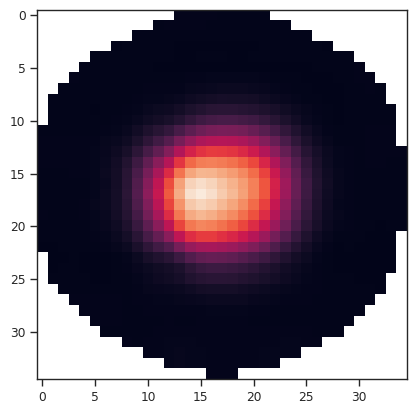

In [132]:
# Visualize the sliced cube:

gbt_cube_specinterp_masked[spec_slicer].moment0().quicklook()

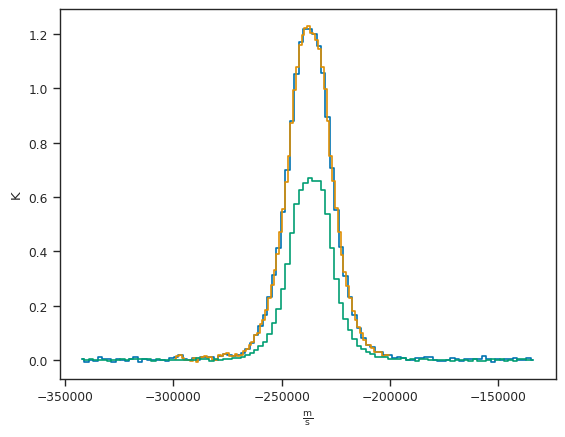

In [133]:
gbt_cube_specinterp_masked.to(u.K).mean(axis=(1, 2)).quicklook()
gbt_cube_masked.to(u.K).spectral_slab(-300*u.km/u.s, -200*u.km/u.s).mean(axis=(1, 2)).quicklook()
vla_cube.to(u.K).mean(axis=(1, 2)).quicklook()

### (Optional): Spectral offset?

Check if there is a spectral offset between the data set.

/home/erickoch/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


254 254
-1 -0.8247049193890125 km / s


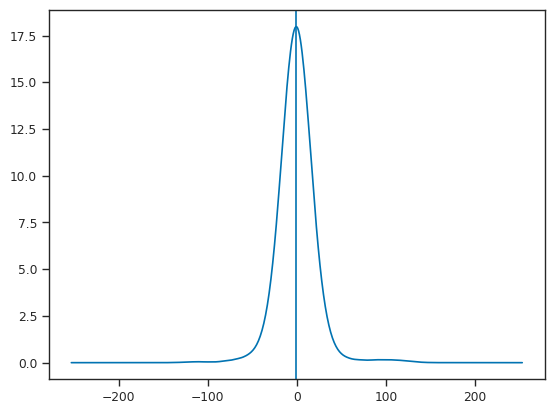

In [92]:
from scipy import signal

y2 = gbt_cube_specinterp_masked.to(u.K).mean(axis=(1, 2)).value[:-1]
y1 = vla_cube.to(u.K).mean(axis=(1, 2)).value[:-1]

print(y2.size, y1.size)

n = y1.size


correlation = signal.correlate(y1, y2, mode="full")
lags = signal.correlation_lags(y1.size, y2.size, mode="full")
lag = lags[np.argmax(correlation)]
print(lag, target_resolution * lag)

plt.plot(lags, correlation)
plt.axvline(lag)

### 4. Calculate uv-overlap statistics

In [115]:
# Take 40 m as the shortest VLA baseline
# It's technically 25 m, but 40 m seems to work better based on the archival M31 and M33.

hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())


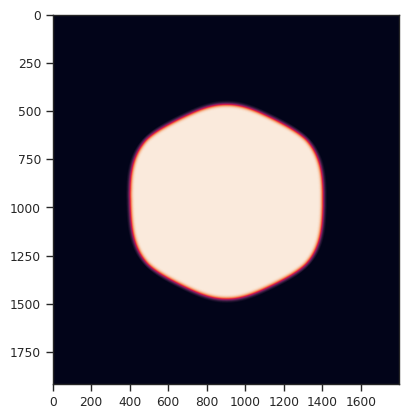

In [116]:
def taper_weights(pb_plane,
                erosion_interations=5):

    # mask = np.logical_or(np.isfinite(pb_plane), pb_plane > 0.)
    mask = pb_plane > 0.

    if erosion_interations > 0:
        mask = nd.binary_erosion(mask, iterations=erosion_interations)

    smoothed_weights = nd.gaussian_filter(mask.astype(float), sigma=erosion_interations/2.)

    weight_arr = pb_plane * smoothed_weights

    return weight_arr

weights = taper_weights(np.isfinite(vla_cube[0]), erosion_interations=20)

plt.imshow(weights)


In [117]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_cube_specinterp_masked.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 weights=weights,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


/home/erickoch/anaconda3/envs/pyuvdata_ewk/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/erickoch/anaconda3/envs/pyuvdata_ewk/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/erickoch/anaconda3/envs/pyuvdata_ewk/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/erickoch/anaconda3/envs/pyuvdata_ewk/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/erickoch/anaconda3/envs/pyuvdata_ewk/lib/python3.10/site-packages/astropy/units/qu

In [44]:
# high_pts[-1]

# low_pts[-1]

Optimization terminated successfully.
         Current function value: 1.399324
         Iterations: 39
         Function evaluations: 76
0.93+/-0.00


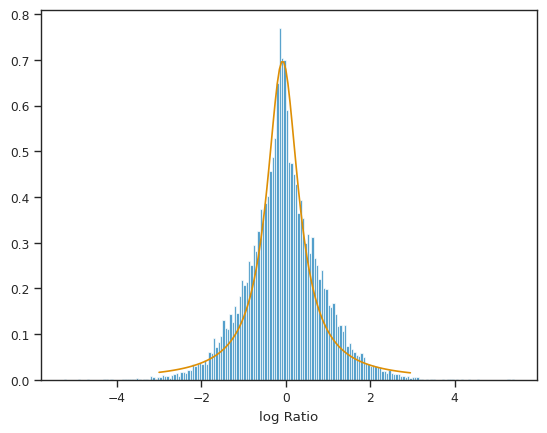

In [119]:
# Using the entire spectral axis:

sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[:-1]),
                                      np.hstack(high_pts[:-1]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

Optimization terminated successfully.
         Current function value: 0.412174
         Iterations: 40
         Function evaluations: 78
0.90+/-0.00


(-1.0, 1.0)

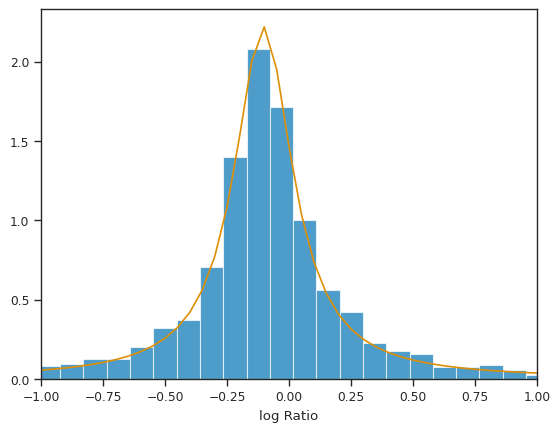

In [120]:
# Using only the velocity range of the target:

sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[spec_slicer]),
                                      np.hstack(high_pts[spec_slicer]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

plt.xlim([-1, 1])

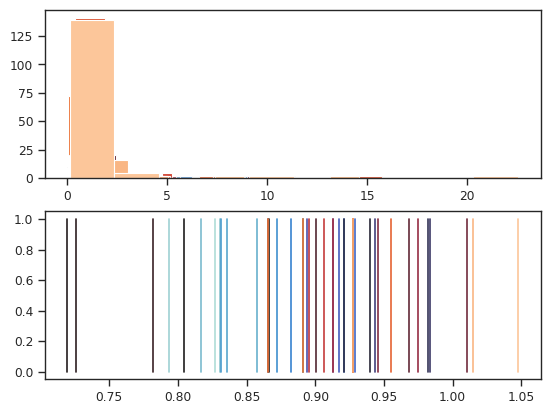

In [121]:
# Check for a dependence on velocity:

fig, axs = plt.subplots(2, 1, sharex=False)

cmap = sns.color_palette("icefire", n_colors=chan_max - chan_min, as_cmap=False)


for ii, this_ratio in enumerate(ratios[spec_slicer]):

    _ = axs[0].hist(this_ratio, label=f"{ii}", color=cmap[ii])

    axs[1].plot(2 * [np.median(this_ratio)], [0, 1], color=cmap[ii])


In [23]:
# print(cmap)

In [27]:
## Check on whether there's Gibbs ringing that's affecting the single dish FFT
from turbustat.statistics import PowerSpectrum

for chan in gbt_cube_specinterp_masked[spec_slicer]:

    pspec_gbt = PowerSpectrum(chan.hdu).run(verbose=True,
                                            radial_pspec_kwargs=dict(method='binned_statistic'),
                                            apodize_kernel='tukey',
                                            high_cut=10**-0.6 / u.pix)

ModuleNotFoundError: No module named 'turbustat'

This appears to be relatively stable. Given that the difference is >5%, the expected absolute flux uncertainty, we will apply this scaling during the feathering process.

The scaling is applied to the single dish data, and so, `<1` implies the interferometer recovers a _lower_ apparent flux, while `>1` implies the single dish has a _higher_ apparent flux.



In [25]:
sc_factor

0.9174707753399566

### 6. Feather the cubes

Do the feathering to create the final cubes, using the single dish scaling factor solved for above.

In [26]:
from uvcombine import feather_simple_cube

In [27]:
# gbt_cube_specinterp_masked.header
target_hdr = vla_cube.header.copy()
target_hdr['TIMESYS'] = target_hdr['TIMESYS'].lower()

In [28]:
# Grid the GBT data to the VLA grid
gbt_cube_specinterp_reproj = gbt_cube_specinterp.reproject(target_hdr)

# And specifically apply the same PB coverage
gbt_cube_specinterp_reproj = gbt_cube_specinterp_reproj.with_mask(np.isfinite(vla_cube[0]))

KeyboardInterrupt: 

In [ ]:
np.max(gbt_cube_specinterp_reproj.spectral_axis - vla_cube.spectral_axis)

In [ ]:
vla_cube.spectral_extrema

In [ ]:
# Allow reading in the whole cube.
gbt_cube_specinterp_reproj.allow_huge_operations = True

# Feather with the SD scale factor applied
feathered_cube = feather_simple_cube(vla_cube.to(u.K),
                                     gbt_cube_specinterp_reproj.to(u.K),
                                     allow_lo_reproj=True,
                                     allow_spectral_resample=False,
                                     lowresscalefactor=sc_factor)

# NaN out blank areas post-FFT.
feathered_cube = feathered_cube.with_mask(vla_cube.mask)


In [ ]:
feathered_cube.write(vla_data_path / "ngc6822_C+D_hilores_feathered.fits", overwrite=True)